In [3]:
import os, sys
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

sys.path.append('..')
from script.utils import *
from Class.PlotConfig import *

In [4]:
first_date = to_datetime('02-29-2020')
last_date = to_datetime('05-17-2022')

In [6]:
df = pd.read_csv('../2022_May/Total.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]
original = df.describe().reset_index()
print('Original')
print(original)

print('Cleaned')
df = pd.read_csv('../2022_May_target_cleaned/Total.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]
cleaned = df.describe().reset_index()
print(cleaned)

Original
   index          FIPS       AgeDist    HealthDisp  DiseaseSpread  \
0  count  2.541878e+06  2.541878e+06  2.541878e+06   2.541878e+06   
1   mean  3.038365e+04  5.755118e-01  3.679735e-01   1.500998e-01   
2    std  1.516010e+04  9.445455e-02  1.981330e-01   1.940295e-01   
3    min  1.001000e+03  0.000000e+00  0.000000e+00   0.000000e+00   
4    25%  1.817700e+04  5.215000e-01  2.000000e-01   2.250000e-02   
5    50%  2.917600e+04  5.797000e-01  3.655500e-01   8.380000e-02   
6    75%  4.508100e+04  6.336000e-01  5.297000e-01   2.011000e-01   
7    max  5.604500e+04  1.000000e+00  1.000000e+00   1.000000e+00   

   Transmission  VaccinationFull    SocialDist         Cases        Deaths  \
0  2.541878e+06     2.541878e+06  2.541878e+06  2.541878e+06  2.541878e+06   
1  4.916023e-01     2.060883e+01  7.842961e-01  3.166693e+01  3.775842e-01   
2  2.103357e-01     2.292209e+01  2.283616e-01  3.374052e+02  2.853001e+00   
3  0.000000e+00     0.000000e+00  0.000000e+00  0.000000e

In [7]:
original = original.round(3)
cleaned = cleaned.round(3)

stats = ['mean', 'std']
for feature in cleaned.columns:
    line = feature
    for stat in stats:
        value = original[original['index']==stat][feature].values[0]
        line += f' & {value}'

    for stat in stats:
        value = cleaned[cleaned['index']==stat][feature].values[0]
        line += f' & {value}'
    line += ' \\\\'
    print(line)

index & mean & std & mean & std \\
FIPS & 30383.649 & 15160.098 & 30383.649 & 15160.098 \\
AgeDist & 0.576 & 0.094 & 0.576 & 0.094 \\
HealthDisp & 0.368 & 0.198 & 0.368 & 0.198 \\
DiseaseSpread & 0.15 & 0.194 & 0.15 & 0.193 \\
Transmission & 0.492 & 0.21 & 0.491 & 0.21 \\
VaccinationFull & 20.609 & 22.922 & 20.609 & 22.923 \\
SocialDist & 0.784 & 0.228 & 0.795 & 0.229 \\
Cases & 31.667 & 337.405 & 27.183 & 174.15 \\
Deaths & 0.378 & 2.853 & 0.239 & 2.244 \\
TimeFromStart & 404.0 & 233.538 & 404.0 & 233.538 \\
LinearSpace & 0.5 & 0.289 & 0.5 & 0.289 \\
SinWeekly & -0.001 & 0.707 & -0.001 & 0.707 \\
CosWeekly & 0.003 & 0.707 & 0.003 & 0.707 \\


In [8]:
target_df = None
merge_keys = ['FIPS', 'Date']

first_date = to_datetime('02-29-2020')
last_date = to_datetime('05-17-2022')
dataPath = '../../dataset_raw/CovidMay17-2022/'

targets = ['Cases', 'Deaths']
for feature_name in targets:
    file_name = f'{feature_name}.csv'


    print(f'Reading {file_name}')
    df = read_feature_file(dataPath, file_name)
    
    # check whether the Date column has been pivoted
    if 'Date' not in df.columns:
        df = convert_cumulative_to_daily(df)
        df.fillna(0, inplace=True)
        # df = remove_outliers(df, verbose=False)

        # technically this should be set of common columns
        id_vars = [col for col in df.columns if not valid_date(col)]
        df = df.melt(
            id_vars= id_vars,
            var_name='Date', value_name=feature_name
        ).reset_index(drop=True)
    else:
        df.fillna(0, inplace=True)
        # df = remove_outliers(df, verbose=False)

    # some days had old covid cases fixed by adding neg values
    df.loc[df[feature_name]<0, feature_name] = 0
    
    # can be needed as some feature files may have different date format
    df['Date'] = to_datetime(df['Date'])
    print(f'Min date {df["Date"].min()}, max date {df["Date"].max()}')
    df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]

    print(f'Length {df.shape[0]}.')

    if target_df is None: target_df = df
    else:
        # if a single file has multiple features
        if type(feature_name) == list:
            selected_columns = merge_keys + feature_name
        else:
            selected_columns = merge_keys + [feature_name]

        target_df = target_df.merge(df[selected_columns], how='outer',on=merge_keys)

        # however, we don't need to keep mismatch of FIPS
        target_df = target_df[~target_df['FIPS'].isna()]
    print()

Reading Cases.csv
Min date 2020-01-22 00:00:00, max date 2022-05-25 00:00:00
Length 2541878.

Reading Deaths.csv
Min date 2020-01-22 00:00:00, max date 2022-05-15 00:00:00
Length 2535594.



In [9]:
targets = ['Cases', 'Deaths']
target_df = target_df.groupby(['Date'])[targets].aggregate('sum').reset_index()

target_df.head()

,Date,Cases,Deaths
0,2020-02-29,62,1.0
1,2020-03-01,46,0.0
2,2020-03-02,114,5.0
3,2020-03-03,91,1.0
4,2020-03-04,106,4.0


In [10]:
figPath = '../results/'

def plot(df, target, scale_y:int=1e3, x_major_ticks:int=DATE_TICKS, figure_name:str=None):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x_column = 'Date'

    plt.plot(df[x_column], df[target])
    plt.ylim(bottom=0)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    plt.xticks(rotation = 45)
        
    if scale_y > 1:
        ax.yaxis.set_major_formatter(get_formatter(scale_y))
        
        if scale_y==1e3: unit = 'in thousands'
        elif scale_y==1e6: unit = 'in millions'
        else: unit = f'x {scale_y:.0e}'

        plt.ylabel(f'Daily {target} ({unit})')
    else:
        plt.ylabel(f'Daily {target}')

    fig.tight_layout()

    if figure_name is not None:
        plt.savefig(os.path.join(figPath, figure_name), dpi=DPI)
    plt.show()

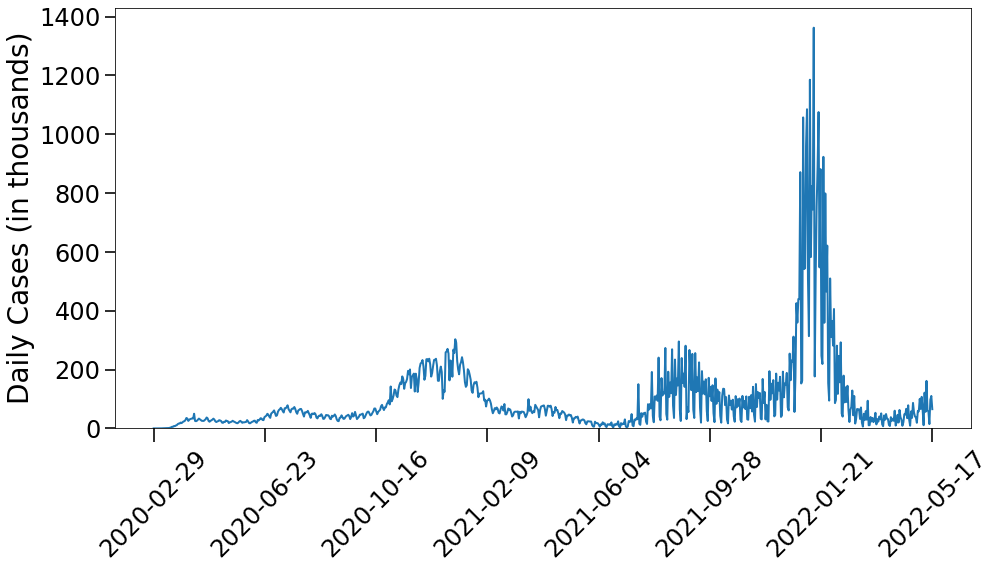

In [11]:
plot(target_df, 'Cases', figure_name='Cases-original.jpg')

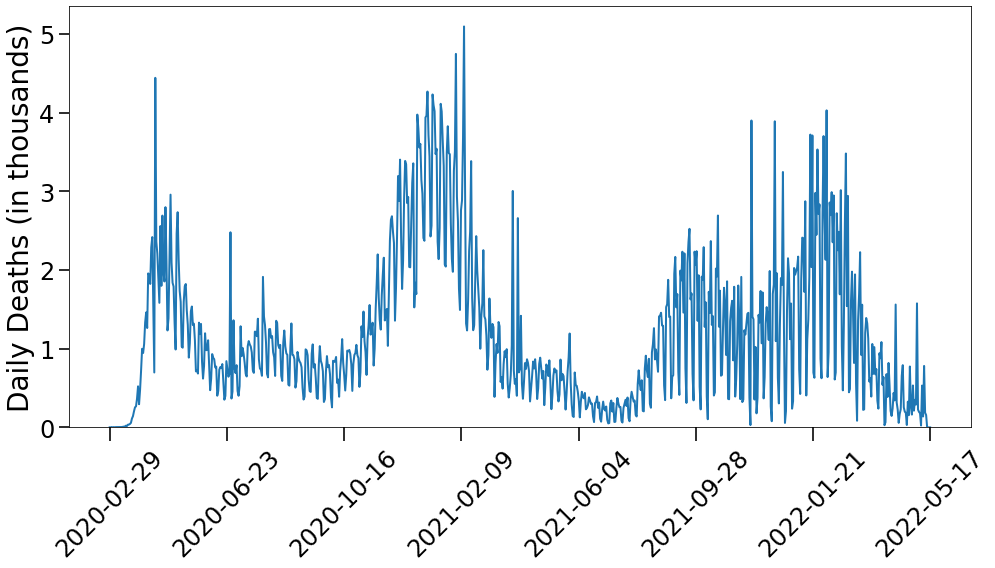

In [12]:
plot(target_df, 'Deaths', figure_name='Deaths-original.jpg')

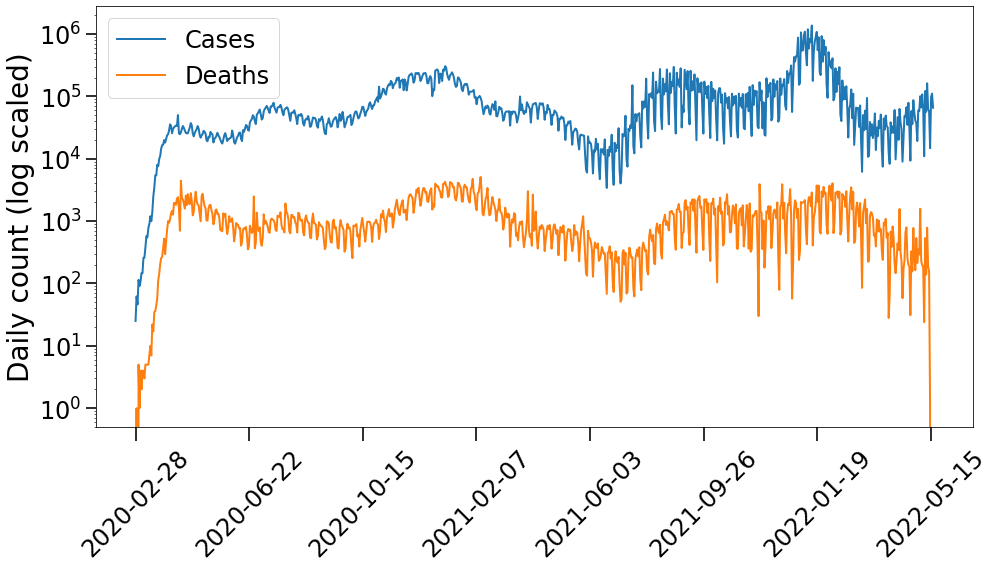

In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for target in targets:
    plt.plot(target_df['Date'], target_df[target], label=target)

x_first_tick = df['Date'].min()
x_last_tick = df['Date'].max()
x_major_ticks = DATE_TICKS
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
plt.xticks(rotation = 45)
plt.yscale('log')
plt.ylabel(f'Daily count (log scaled)')

plt.legend()
fig.tight_layout()
plt.savefig(os.path.join(figPath, 'Combined-log-scaled.jpg'), dpi=DPI)
plt.show()

In [10]:
# train_start = to_datetime('03-10-2020')
# validation_start = to_datetime('01-15-2022')
# test_start= to_datetime('04-16-2022')
# test_end = to_datetime('07-28-2022')

# train_days = (validation_start - train_start).days
# val_days = (test_start  - validation_start).days
# test_days = (test_end - test_start).days + 1
# train_days,train_days%13, val_days,val_days%13, test_days, test_days%13